In [1]:
import os 
import sys 
sys.path.append('./src')
import pandas as pd 
import re
from occm import *
from cvrg import *  
from ncbi import download
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import matplotlib.cm
import matplotlib.colors 
from files import FastaFile

DATA_DIR = os.path.abspath('./data')

%load_ext autoreload
%autoreload 2

In [71]:
genome_ids = pd.read_csv('./data/genomes.csv', usecols=['accession']).values.ravel()
genome_ids = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in genome_ids]
download(genome_ids, path='./data/genomes/')

download_genomes:   0%|          | 0/196 [00:00<?, ?it/s]

download_genomes: 100%|██████████| 196/196 [11:51<00:00,  3.63s/it]


Total genomes: 196


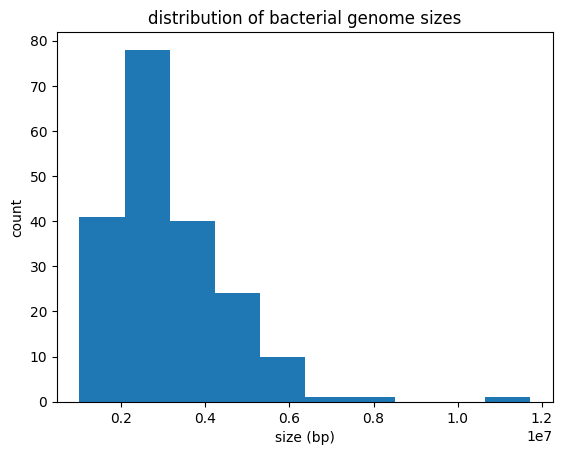

In [3]:
# Take a look at the length distributions of the genomes obtained from NCBI. 
genomes_df = pd.read_csv(os.path.join(DATA_DIR, 'genomes.csv'))
print('Total genomes:', len(genomes_df))
genome_sizes = genomes_df.genome_size.values 

fig, ax = plt.subplots()
ax.hist(genome_sizes)
ax.set_title('distribution of bacterial genome sizes')
ax.set_ylabel('count')
ax.set_xlabel('size (bp)')
plt.show()

Mean genome size: 3718969.3


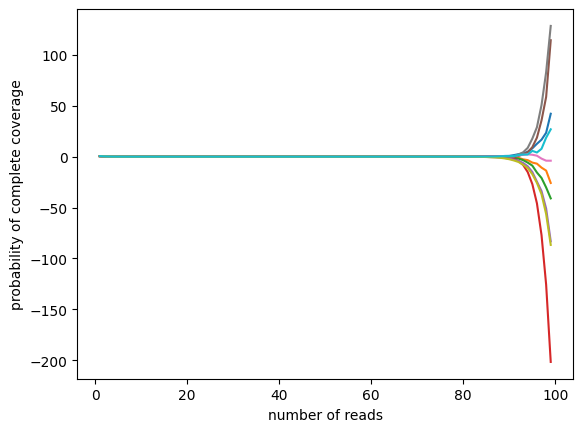

In [40]:
total_reads = 25000000 # Woody said this is a reasonable read depth. 
read_length = 300

# Could be problematic to be tuning abundances, because then it's going to be a 196-variable equation. 
# I also think that because I can't just set abundance to zero? But maybe?
# Actually, I think what I might do is set abundance to 1, and let the read count be alpha * total_reads. 

genomes_df_subset = genomes_df.sample(10) # Grab a few of the genomes for now. 
fig, ax = plt.subplots(1)

print('Mean genome size:', genomes_df_subset.genome_size.mean())

for row in genomes_df_subset.itertuples():
    x_vals = np.arange(1, 100)
    # Maybe want to tune total reads, and use this to inform abundance?
    y_vals = [coverage_wendl_2013(alpha=0.12, R=int(x), L=read_length, gamma=int(row.genome_size)) for x in x_vals]
    ax.plot(x_vals, y_vals)

ax.set_xlabel('number of reads')
ax.set_ylabel('probability of complete coverage')
plt.show()
# Want to have a plot with abundance on the x-axis and probability of complete coverage on the y-axis. 

In [53]:
# Trying this with values from the paper...
R = 0.12 * 4.5e6
# coverage_wendl_2013(alpha=0.12, R=4.5e6, gamma=2936981, L=100)
# coverage_wendl_2013(alpha=1, R=540000.0, gamma=2936981, L=100)
coverage_wendl_2013(alpha=1, R=1000, gamma=2936981, L=100)

coverage_wendl_2013: Current value of summation is -3.554651436523099e+39.:   2%|▏         | 19/1001 [00:00<00:01, 941.49it/s] 

coverage_wendl_2013: Current value of summation is -9.618379061650967e+278.: 100%|██████████| 1001/1001 [00:01<00:00, 609.57it/s] 


Decimal('-9.618379061650965133205836854E+278')

In [4]:
# Download the latest GTDB bacteria metadata from the FTP site https://data.gtdb.ecogenomic.org/releases/latest/
gtdb_metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'bac120_metadata_r220.tsv'), sep='\t')
print(len(gtdb_metadata_df), 'total genome entries in GTDB.')
# Filter for complete genomes. 
gtdb_metadata_df = gtdb_metadata_df[gtdb_metadata_df.ncbi_genome_representation == 'full']
print(len(gtdb_metadata_df), 'total complete genome entries in GTDB.')

584382 total genome entries in GTDB.
584319 total complete genome entries in GTDB.


In [33]:
# for col in gtdb_metadata_df.columns:
#     print(col)

In [30]:
def get_taxonomy(gtdb_metadata_df:pd.DataFrame, level:str='p'):
    '''Extract the taxonomy from the lineage string in the metadata.'''
    taxonomy = []
    for entry in gtdb_metadata_df.gtdb_taxonomy:
        match = re.search(f'{level}__([^;]+)', entry)
        if match is None:
            taxonomy.append(None)
        else:
            taxonomy.append(match.group(1))
    return taxonomy

In [31]:
gtdb_metadata_df['phylum'] = get_taxonomy(gtdb_metadata_df)
print(len(gtdb_metadata_df.phylum.unique()), 'unique phyla present in the data.')

196 unique phyla present in the data.


In [35]:
# Get the genomes with the highest checkm_completeness from each phylum. 
gtdb_metadata_df = gtdb_metadata_df.sort_values('checkm_completeness', ascending=False).groupby('phylum', as_index=False).first()

In [37]:
gtdb_metadata_df.set_index('accession').to_csv('./data/genomes.csv')

In [50]:
genome = Genome('./data/sequence.fn', read_size=200)
# B = len(genome)
# print(f'Genome contains {B} base pairs.')

Genome.__init__: Loaded 1 sequences from the FASTA file.


In [26]:
def get_max_contig_lengths(genome:Genome, read_depth:int=10000, n_samples:int=500):
    max_contig_lengths = []
    for _ in tqdm(range(n_samples), desc='get_max_contig_lengths'):
        genome.build_graphs(read_depth=read_depth)

        # # What is the average number of next nodes?
        # graph = genome.seqs[0].graph
        # avg_next = np.mean([len(read.next) for read in graph.reads.values()])
        # print('Average number of "next" nodes:', avg_next)

        contigs = genome.get_contigs()
        max_contig_lengths.append(max([len(contig) for contig in contigs]))

    return np.array(sorted(max_contig_lengths))

In [53]:
coverages = []
for i in range(100):
    genome.build_graphs(read_depth=10000)
    contigs = genome.get_contigs()
    coverages.append(genome.seqs[0].get_coverage(contigs))
np.mean(coverages)

np.float64(0.31974004083029056)

Number of bins: 46415
Probability of at least one read occurring in any given bin: 0.3500759873747368


get_max_contig_lengths: 100%|██████████| 500/500 [01:04<00:00,  7.79it/s]

Biggest max contig length: 2800


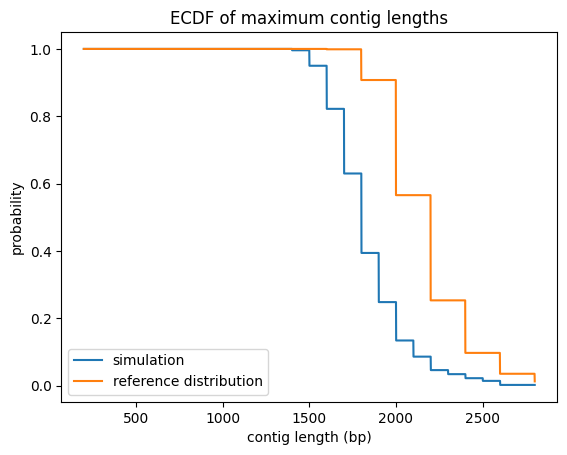

In [45]:
# Plot an ECDF of the maximum contig lengths from different attempts at reading the same genome. 
read_size = 200
read_depth = 20000 
alpha = genome.n_bins()
beta = 1 - (1 - 1 / alpha) ** read_depth # This is the probability of at least one read occurring in every bin. 
print('Number of bins:', alpha)
print('Probability of at least one read occurring in any given bin:', beta) # np.round(beta, 2))

max_contig_lengths = get_max_contig_lengths(genome, read_depth=read_depth, n_samples=500)
print('Biggest max contig length:', max(max_contig_lengths))

fig, ax = plt.subplots()

x_vals, y_vals = [], []
for l in np.arange(read_size, max(max_contig_lengths) + 1):
    x_vals.append(l)
    y_vals.append(np.mean(max_contig_lengths >= l))

y_vals_ref = [pcgtk(r=read_depth, k=x // read_size, b=len(genome), l=read_size) for x in x_vals]

# I think it would be better to put contig length in terms of number of reads, to mirror the paper. 
ax.plot(x_vals, y_vals)
ax.plot(x_vals, y_vals_ref)

ax.legend(['simulation', 'reference distribution'])
ax.set_xlabel('contig length (bp)')
ax.set_ylabel('probability')
ax.set_title('ECDF of maximum contig lengths')
plt.show()


Plotting curves...: 100%|██████████| 196/196 [00:00<00:00, 628.47it/s]


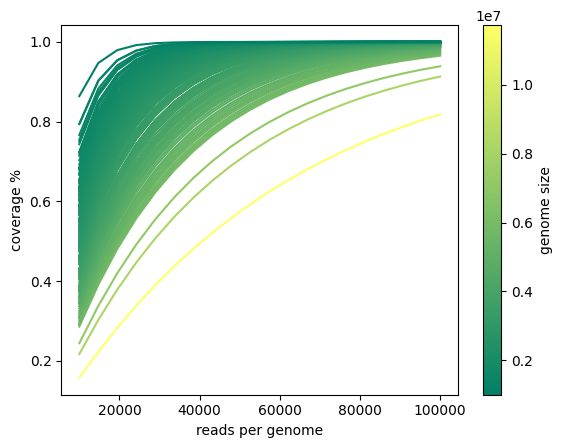

In [2]:
# coverage_lander_waterman_1998(G:int=None, L:int=None, R:int=None, alpha:float=None, T:float=int)

read_size = 200
read_depth = 1e6

fig, ax = plt.subplots()
 
x_vals = np.linspace(0.01, 0.1, 20)
genomes_df = pd.read_csv(os.path.join(DATA_DIR, 'genomes.csv')).sort_values('genome_size', ascending=False)
genome_sizes = genomes_df.genome_size.values.ravel()

norm = matplotlib.colors.Normalize(vmin=min(genome_sizes), vmax=max(genome_sizes))
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap='summer')

for size in tqdm(genome_sizes, desc='Plotting curves...'):
    y_vals = []
    for x in x_vals:
        E = coverage_lander_waterman_1998(G=size, R=read_depth, L=read_size, alpha=x, T=read_size // 2)
        E = E / size
        y_vals.append(E)
    ax.plot(np.array(x_vals) * read_depth, y_vals, c=cmap.to_rgba(size))

ax.set_ylabel('coverage %')
ax.set_xlabel('reads per genome')

cbar = plt.colorbar(ax=ax, mappable=cmap)
cbar.set_label('genome size')
# ax.legend(genome_sizes)
plt.show()

In [17]:
composition_lander_waterman_1998(0.95, genomes_df, L=200)

(9204978,
 array([0.01909006, 0.01332331, 0.0116476 , 0.0096733 , 0.0095273 ,
        0.00947623, 0.00939676, 0.00924065, 0.00904584, 0.00887383,
        0.00887221, 0.00880789, 0.00878298, 0.00861423, 0.00845668,
        0.00830452, 0.00809601, 0.00793307, 0.00776234, 0.00770829,
        0.00767486, 0.00764978, 0.00761732, 0.00761447, 0.00754826,
        0.00740102, 0.00738765, 0.00737693, 0.00725482, 0.00722232,
        0.00714073, 0.00699165, 0.00697493, 0.00696225, 0.00689386,
        0.00689291, 0.00687368, 0.00680246, 0.00674432, 0.00674017,
        0.00672558, 0.00663651, 0.00659945, 0.00659756, 0.00644792,
        0.00630584, 0.00623513, 0.00622652, 0.00619161, 0.00615408,
        0.00608747, 0.0060437 , 0.00596954, 0.00596716, 0.00595899,
        0.00590358, 0.00583272, 0.00581892, 0.00581753, 0.00579973,
        0.00579337, 0.00578733, 0.00558184, 0.00557847, 0.00556653,
        0.00552021, 0.00545011, 0.00539582, 0.00538025, 0.00537057,
        0.00536037, 0.00530603, 0.0052

In [20]:
genomes_df

,accession,phylum,ambiguous_bases,checkm2_completeness,checkm2_contamination,checkm2_model,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
138,RS_GCF_020103725.1,Myxococcota,0,100.00,3.26,Specific,100.00,3.41,245,c__Deltaproteobacteria (UID3216),...,1491,2754,0,100,DQ768110.1.1491,Bacteria;Myxococcota;Myxococcia;Myxococcales;M...,0,19,77,1
101,GB_GCA_016713535.1,JADJOY01,0,86.62,2.05,General,91.79,2.52,190,k__Bacteria (UID3187),...,1555,2187,0,92.154,JN977187.1.1551,Bacteria;Desulfobacterota;uncultured;unculture...,0,19,47,0
85,GB_GCA_019637335.1,Hydrogenedentota,0,96.17,0.88,General,100.00,3.48,147,k__Bacteria (UID2495),...,1530,2593,0,97.32,FPLP01007929.3.1528,Bacteria;Hydrogenedentes;Hydrogenedentia;Hydro...,0,19,46,0
150,RS_GCF_900590705.1,Pseudomonadota,0,100.00,0.40,Specific,100.00,0.22,812,o__Pseudomonadales (UID4488),...,1525,2811,0,99.934,LT855380.897831.899355,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,0,19,63,0
126,GB_GCA_029561455.1,KSB1,0,98.80,1.95,General,98.90,3.30,147,k__Bacteria (UID2495),...,1521,2108,0,91.65,EU246021.1.1510,Bacteria;Calditrichota;Calditrichia;Calditrich...,0,19,49,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,RS_GCF_000020945.1,Coprothermobacterota,0,99.46,0.10,Specific,100.00,0.00,102,k__Bacteria (UID203),...,1523,2813,0,100,CP001145.1131856.1133378,Bacteria;Coprothermobacterota;Coprothermobacte...,0,19,47,1
187,GB_GCA_030615855.1,UBP18,0,93.58,1.30,General,88.76,2.25,143,k__Bacteria (UID2495),...,none,none,none,none,none,none,0,17,38,0
8,GB_GCA_030672545.1,Aerophobota,0,89.23,0.12,General,91.53,0.85,105,k__Bacteria (UID209),...,1589,1962,0,89.05,ASMN01000059.2525.4105,Bacteria;Aerophobota;Aerophobia;Aerophobales;A...,0,14,22,0
190,GB_GCA_002716355.1,UBP7,489,86.57,1.11,General,89.50,0.00,104,k__Bacteria (UID203),...,none,none,none,none,none,none,0,18,39,0


In [11]:
def get_contigs(coverage:float, genomes_df:pd.DataFrame, read_size:int=200, path:str=None):
    
    # First, want to get the required read depth and abundances to meet the specified coverage standard. 
    read_depth, abundances = composition_lander_waterman_1998(coverage, genomes_df.genome_size.values.ravel(), read_size=read_size)
    genomes_df['abundance'] = abundances # Add abundances to the DataFrame. 

    seqs, ids, descriptions = [], [], []

    for row in tqdm(list(genomes_df.itertuples()), desc='get_contigs'):
        # Get the genome ID and remove the GenBank or RefSeq prefix. 
        genome_id = row.accession.replace('GB_', '').replace('RS_', '')
        genome = Genome(os.path.join(DATA_DIR, 'genomes', f'{genome_id}.fn'), read_size=read_size)
        genome.build_graphs(read_depth=int(read_depth * row.abundance))
        contigs = genome.get_contigs()
        
        seqs += [str(contig) for contig in contigs]
        # Set the contig ID to be the genome ID followed by an underscore and an integer ID. 
        ids += [f'{genome_id}_{i}' for i in range(len(contigs))]
        descriptions = [f'abundance={row.abundance}'] * len(contigs)

    file = FastaFile(seqs=seqs, ids=ids, descriptions=descriptions)
    file.write(path)
    print(f'get_contigs: FASTA file written to {path}')

        
        

In [13]:
get_contigs(0.95, genomes_df, path=os.path.join(DATA_DIR, 'contigs_coverage_95.fn'))

get_contigs: 100%|██████████| 196/196 [02:02<00:00,  1.60it/s]

get_contigs: FASTA file written to /home/prichter/Documents/binning/data/contigs_coverage_95.fn
